In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load datasets
customers = pd.read_csv('/content/Customers.csv')
products = pd.read_csv('/content/Products.csv')
transactions = pd.read_csv('/content/Transactions.csv')

# Merge datasets
merged_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

# Basic EDA
print("=== Missing Values ===")
print(merged_data.isnull().sum())

print("\n=== Data Summary ===")
print(merged_data.describe())

# Time Analysis
merged_data['TransactionDate'] = pd.to_datetime(merged_data['TransactionDate'])
merged_data['SignupDate'] = pd.to_datetime(merged_data['SignupDate'])
merged_data['TransactionYearMonth'] = merged_data['TransactionDate'].dt.to_period('M')

=== Missing Values ===
TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price_x            0
CustomerName       0
Region             0
SignupDate         0
ProductName        0
Category           0
Price_y            0
dtype: int64

=== Data Summary ===
          Quantity   TotalValue     Price_x     Price_y
count  1000.000000  1000.000000  1000.00000  1000.00000
mean      2.537000   689.995560   272.55407   272.55407
std       1.117981   493.144478   140.73639   140.73639
min       1.000000    16.080000    16.08000    16.08000
25%       2.000000   295.295000   147.95000   147.95000
50%       3.000000   588.880000   299.93000   299.93000
75%       4.000000  1011.660000   404.40000   404.40000
max       4.000000  1991.040000   497.76000   497.76000


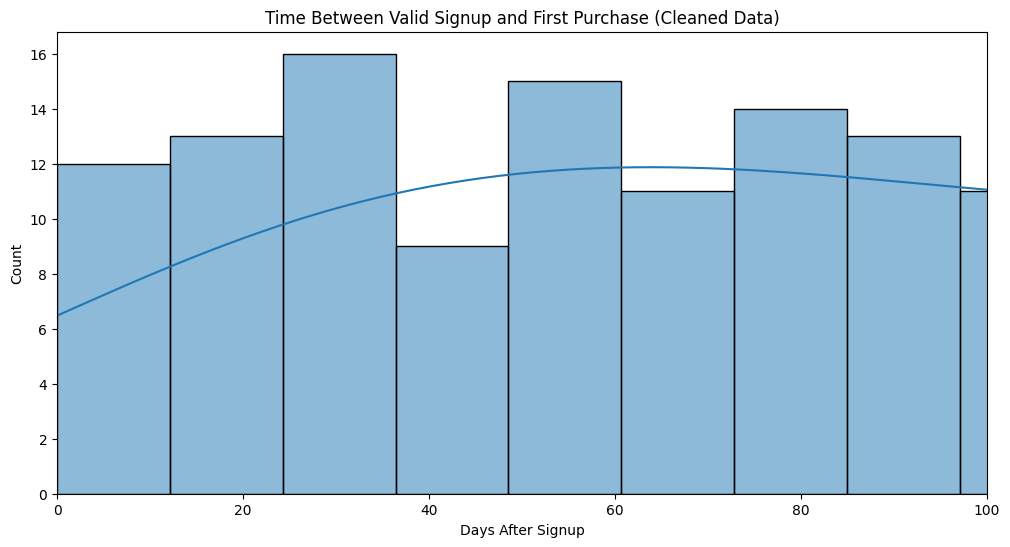

Invalid records (purchase before signup): 201/1000


In [27]:
# Insight 2.1: Customer Acquisition Trends
merged_data['SignupToPurchase'] = (merged_data['TransactionDate'] - merged_data['SignupDate']).dt.days

# Filter out negative values and nonsensical durations (e.g., >365 days)
merged_data_clean = merged_data[
    (merged_data['SignupToPurchase'] >= 0) &
    (merged_data['SignupToPurchase'] <= 365)
]

plt.figure(figsize=(12,6))
sns.histplot(
    data=merged_data_clean,
    x='SignupToPurchase',
    bins=30,
    kde=True,
    edgecolor='black'
)
plt.xlim(0, 100)  # Focus on 0-100 days for meaningful insights
plt.title('Time Between Valid Signup and First Purchase (Cleaned Data)')
plt.xlabel('Days After Signup')
plt.show()

invalid_records = merged_data[merged_data['SignupToPurchase'] < 0].shape[0]
print(f"Invalid records (purchase before signup): {invalid_records}/{len(merged_data)}")

In [28]:
# Insight 2.2: High-Value Customer Identification
merged_data['CustomerLTV'] = merged_data.groupby('CustomerID')['TotalValue'].transform('sum')
high_value = merged_data[merged_data['CustomerLTV'] > merged_data['CustomerLTV'].quantile(0.9)]
print(f"\nHigh-Value Customers (Top 10%): {high_value['CustomerID'].nunique()}")
print(f"Contribution to Revenue: {high_value['TotalValue'].sum() / merged_data['TotalValue'].sum() * 100:.1f}%")


High-Value Customers (Top 10%): 11
Contribution to Revenue: 12.0%


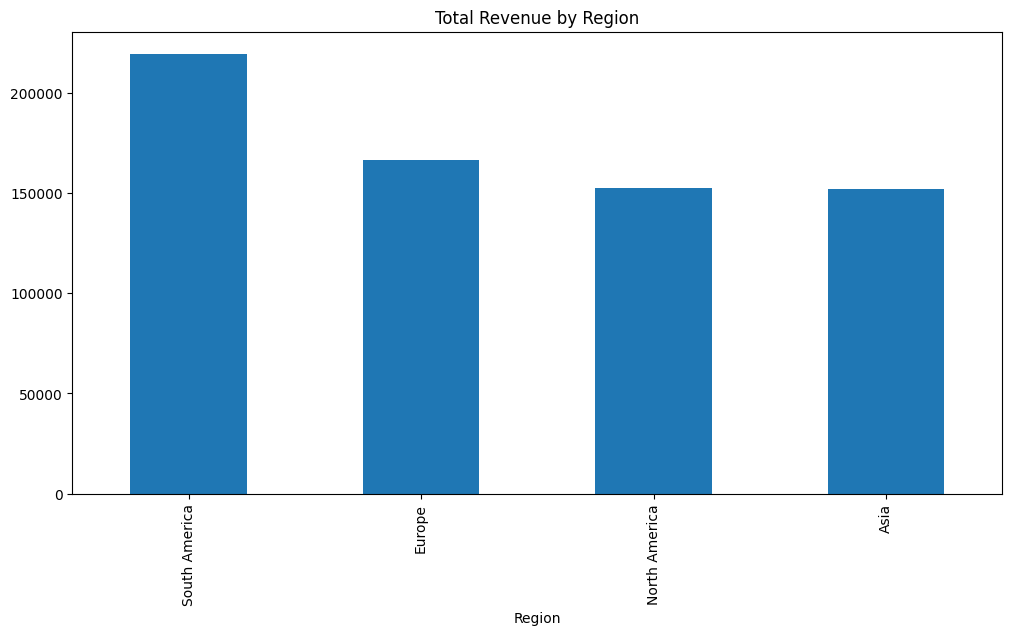

In [10]:
#Insight 4.1: Revenue Analysis
plt.figure(figsize=(12,6))
merged_data.groupby('Region')['TotalValue'].sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Total Revenue by Region')
plt.show()

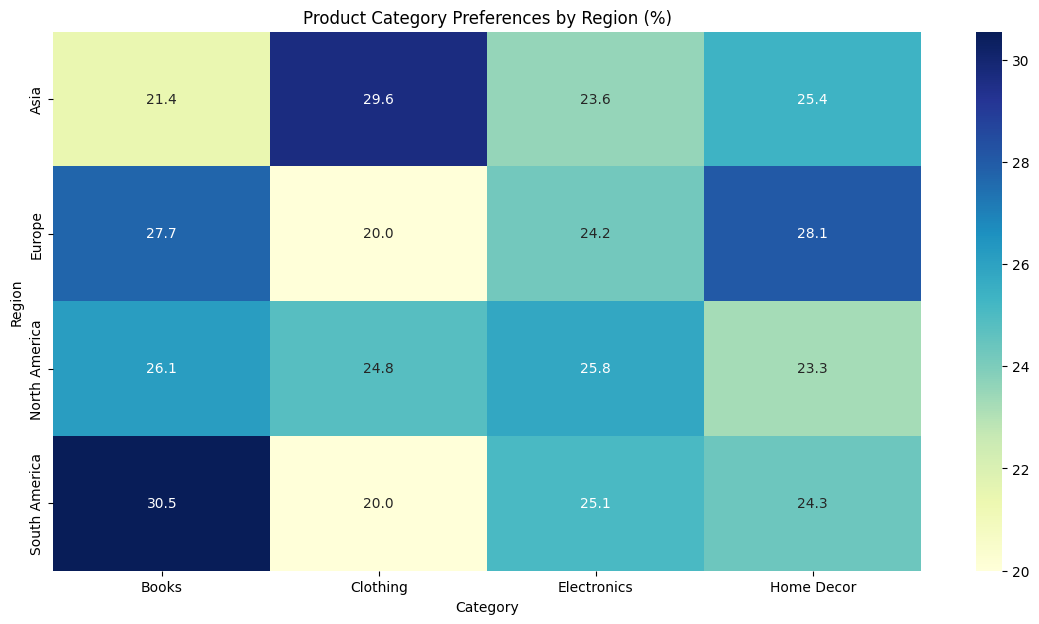

In [22]:
# Insight 4.2: Regional Product Preferences
regional_category = merged_data.groupby(['Region', 'Category'])['Quantity'].sum().unstack()
regional_category_percent = regional_category.div(regional_category.sum(axis=1), axis=0) * 100
plt.figure(figsize=(14,7))
sns.heatmap(regional_category_percent, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Product Category Preferences by Region (%)')
plt.show()

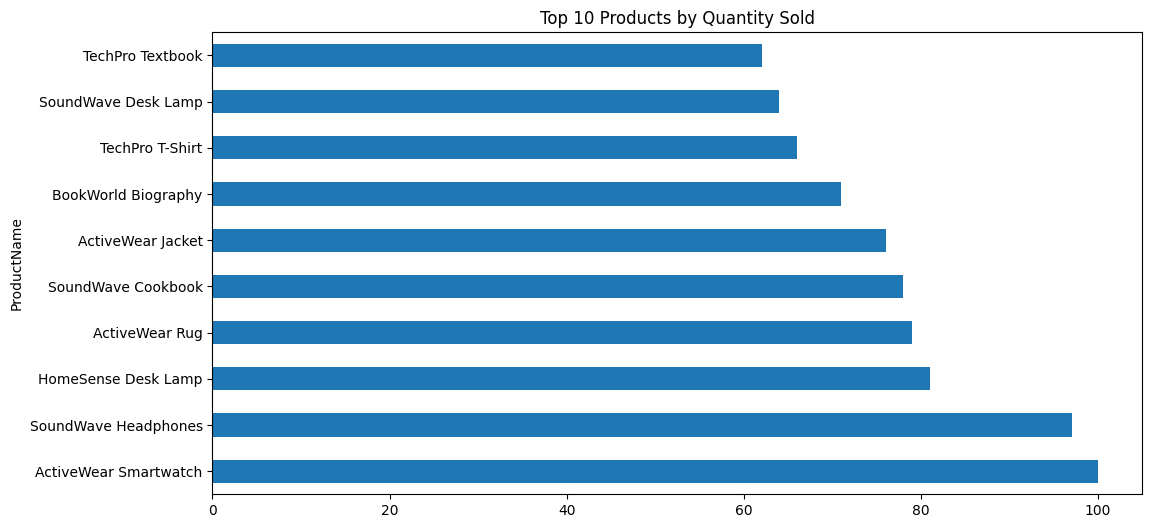

In [12]:
#Insight 5: Top Products Analysis
top_products = merged_data.groupby('ProductName')['Quantity'].sum().nlargest(10)
plt.figure(figsize=(12,6))
top_products.plot(kind='barh')
plt.title('Top 10 Products by Quantity Sold')
plt.show()

<ipython-input-21-ebdba4284793>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Month', y='TotalValue', data=monthly_avg, palette='viridis')


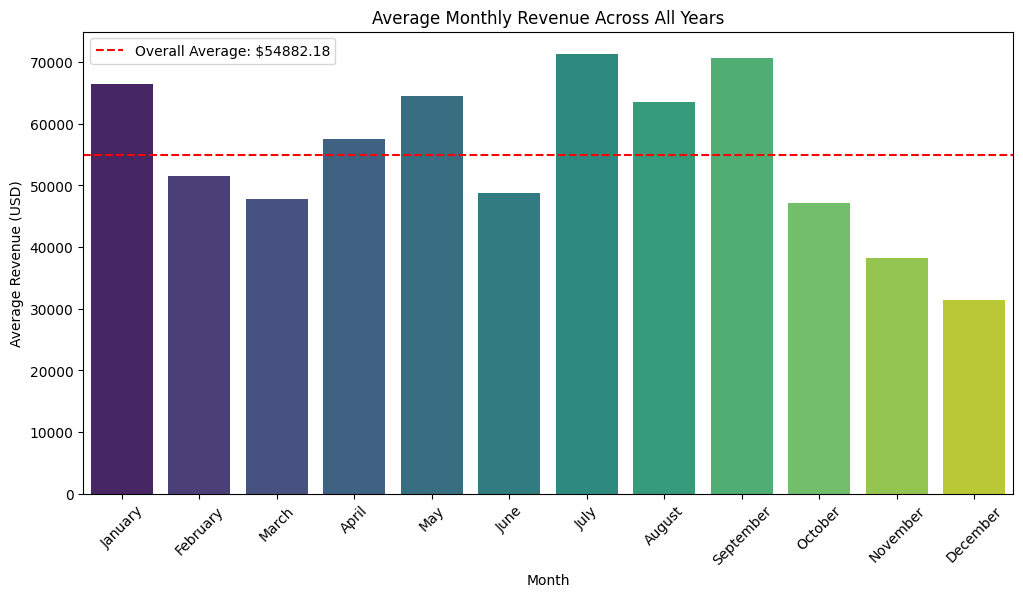

In [21]:
# Insight 6: Monthly Revenue Trends

# Extract month name and year
merged_data['Month'] = merged_data['TransactionDate'].dt.month_name()
merged_data['Year'] = merged_data['TransactionDate'].dt.year

# Calculate average monthly revenue across years
monthly_avg = merged_data.groupby(['Month', 'Year'])['TotalValue'].sum().reset_index()
monthly_avg = monthly_avg.groupby('Month')['TotalValue'].mean().reset_index()

# Define month order for proper sorting
months_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

# Convert to categorical for correct ordering
monthly_avg['Month'] = pd.Categorical(
    monthly_avg['Month'],
    categories=months_order,
    ordered=True
)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Month', y='TotalValue', data=monthly_avg, palette='viridis')
plt.title('Average Monthly Revenue Across All Years')
plt.ylabel('Average Revenue (USD)')
plt.axhline(monthly_avg['TotalValue'].mean(), color='red', linestyle='--',
            label=f'Overall Average: ${monthly_avg["TotalValue"].mean():.2f}')
plt.xticks(rotation=45)
plt.legend()
plt.show()